## Testing of the TotalSegmentator

In [1]:
#Imports
import nibabel as nib
from totalsegmentator.python_api import totalsegmentator
import os
import ipywidgets as widgets
from IPython.display import display
import numpy as np
from ipywidgets import interact, HBox, VBox, widgets
import cv2
from scipy.ndimage import binary_fill_holes, label, center_of_mass

### The segmentation using totalsegmentator

In [2]:
labels = None
with open("Labels.txt", 'r') as file:
    labels = [line.rstrip() for line in file]
print(labels)

['vertebrae_C1', 'vertebrae_C2', 'vertebrae_C3', 'vertebrae_C4', 'vertebrae_C5', 'vertebrae_C6', 'vertebrae_C7', 'vertebrae_T1', 'vertebrae_T2', 'vertebrae_T3', 'vertebrae_T4', 'vertebrae_T5', 'vertebrae_T6', 'vertebrae_T7', 'vertebrae_T8', 'vertebrae_T9', 'vertebrae_T10', 'vertebrae_T11', 'vertebrae_T12', 'vertebrae_L1', 'vertebrae_L2', 'vertebrae_L3', 'vertebrae_L4', 'vertebrae_L5', 'vertebrae_S1']


In [13]:
dir = os.getcwd()
Segmentation_file_path = dir + "/Data/s0011/Segmentation_output.nii.gz"
if not os.path.exists(Segmentation_file_path):
    with open(Segmentation_file_path, 'w') as fp:
      pass
print(os.path.exists(Segmentation_file_path))
input_file_path = dir + "/Data/s0011/ct.nii.gz"
print(os.path.exists(input_file_path))


input_img = nib.load(input_file_path)
Segmentation_output = totalsegmentator(input_img, roi_subset=labels)
nib.save(Segmentation_output, Segmentation_file_path)
del Segmentation_output, input_img

100%|██████████| 4/4 [00:53<00:00, 13.27s/it]


# Slice rendering of segmentation
which is easier to use

In [3]:
def crop_image(out_im):
    non_zero_slices = [i for i in range(out_im.shape[0]) if np.any(out_im[i, :, :])]
    sagital_start = non_zero_slices[0] #Used for image reconstruction
    filtered = out_im[non_zero_slices, :, :]
    non_zero_slices = [i for i in range(filtered.shape[1]) if np.any(filtered[:, i, :])]
    frontal_start = non_zero_slices[0] #Used for image reconstruction
    filtered = filtered[:, non_zero_slices, :]
    non_zero_slices = [i for i in range(filtered.shape[2]) if np.any(filtered[:, :, i])]
    transversal_start = non_zero_slices[0] #Used for image reconstruction
    filtered = filtered[:, :, non_zero_slices]


    return filtered, sagital_start, frontal_start, transversal_start

In [4]:
def read_data(path = "/Data/s0011/Segmentation_output.nii.gz"):
    dir = os.getcwd()
    if os.path.exists(dir + path):
        output_img_new = nib.load(dir + path)
    else:
        print("No file found")

    # Convert to NumPy array
    output_img_data = np.array(output_img_new.dataobj)
    return output_img_new, output_img_data

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import SimpleITK as sitk

#Resets the matplotlib, since totalSegmentator messes with the output
plt.close('all')
plt.switch_backend('module://ipykernel.pylab.backend_inline')

output_img_nifti, output_img_data = read_data()

filtered_data,_,_,_ = crop_image(output_img_data)

print(f"Original number of slices: {output_img_data.shape[0]}")
print(f"Number of slices after filtering: {filtered_data.shape[0]}")

# Define a function to plot sagittal slices
def plot_sagittal(slice_index):
    plt.figure(figsize=(8, 8))

    # Sagittal slice (fixing the first axis, after flipping)
    plt.imshow(filtered_data[slice_index, :, :], cmap='gray')
    plt.title(f"Sagittal Slice {slice_index}")
    plt.axis('off')

    plt.show()
    plt.close()  # Close the figure to avoid warning and memory issues

# Create an interactive slider for sagittal slices
interact(plot_sagittal, slice_index=(0, filtered_data.shape[0] - 1))


Original number of slices: 311
Number of slices after filtering: 59


interactive(children=(IntSlider(value=29, description='slice_index', max=58), Output()), _dom_classes=('widget…

<function __main__.plot_sagittal(slice_index)>

# Vertebra body extraction

In [6]:

def plot_segmentation(vis_arr, value=-1):

    #There might be some other way to define the functions outside of plot_segmentation.
    #But for now I do not care and this works.
    def plot_sagittal(slice_index):
        plt.figure(figsize=(8, 8))

        # Sagittal slice (fixing the first axis, after flipping)
        plt.imshow(vis_arr[slice_index, :, :], cmap='gray')
        plt.title(f"Area of Slice {count_per_sagital_slice[slice_index]}")
        plt.axis('off')

        plt.show()
        plt.close()  # Close the figure to avoid warning and memory issues

    def plot_frontal(slice_index):
        plt.figure(figsize=(8, 8))

        # Sagittal slice (fixing the first axis, after flipping)
        plt.imshow(vis_arr[:, slice_index, :], cmap='gray')
        plt.title(f"Area of Slice {count_per_frontal_slice[slice_index]}")
        plt.axis('off')

        plt.show()
        plt.close()  # Close the figure to avoid warning and memory issues

    def plot_transversal(slice_index):
        plt.figure(figsize=(8, 8))

        # Sagittal slice (fixing the first axis, after flipping)
        plt.imshow(vis_arr[:, :, slice_index], cmap='gray')
        plt.title(f"Area of Slice {count_per_transversal_slice[slice_index]}")
        plt.axis('off')

        plt.show()
        plt.close()  # Close the figure to avoid warning and memory issues


    #Get the area in each slice
    if value != -1:
        count_per_sagital_slice = np.sum(vis_arr == value, axis=(1, 2))
        count_per_frontal_slice = np.sum(vis_arr == value, axis=(0, 2))
        count_per_transversal_slice = np.sum(vis_arr == value, axis=(0, 1))
    else:
        values = np.unique(vis_arr)
        values = values[1:]
        count_per_sagital_slice_list = {}
        count_per_frontal_slice_list = {}
        count_per_transversal_slice_list = {}
        for val in values:
            count_per_sagital_slice_list[val] = np.sum(vis_arr == values[val], axis=(1, 2))
            count_per_frontal_slice_list[val] = np.sum(vis_arr == values[val], axis=(0, 2))
            count_per_transversal_slice_list[val] = np.sum(vis_arr == values[val], axis=(0, 1))
        count_per_sagital_slice = np.sum(list(count_per_sagital_slice_list.values()), axis=0)
        count_per_frontal_slice = np.sum(list(count_per_frontal_slice_list.values()), axis=0)
        count_per_transversal_slice = np.sum(list(count_per_transversal_slice_list.values()), axis=0)



    #Find the maximum point for alls lices
    max_sag = np.argmax(count_per_sagital_slice)
    max_front = np.argmax(count_per_frontal_slice)
    max_trans = np.argmax(count_per_transversal_slice)

    # Create interactive sliders
    sagittal_slider = widgets.IntSlider(min=0, max=vis_arr.shape[0] - 1, value=max_sag, description="Sagittal")
    frontal_slider = widgets.IntSlider(min=0, max=vis_arr.shape[1] - 1, value=max_front, description="Frontal")
    transversal_slider = widgets.IntSlider(min=0, max=vis_arr.shape[2] - 1, value=max_trans, description="Transversal")

    # Create interactive plots
    sagittal_plot = widgets.interactive_output(plot_sagittal, {'slice_index': sagittal_slider})
    frontal_plot = widgets.interactive_output(plot_frontal, {'slice_index': frontal_slider})
    transversal_plot = widgets.interactive_output(plot_transversal, {'slice_index': transversal_slider})

    # Arrange widgets in a horizontal box
    ui = HBox([
        VBox([sagittal_slider, sagittal_plot]),
        VBox([frontal_slider, frontal_plot]),
        VBox([transversal_slider, transversal_plot])
    ])

    display(ui)
    

In [44]:
def hole_find(binary_image_arg, invert = False, plot=False):

    #Look at nearby slices if the starting one does not have center hole
    start_index = np.argmax(np.sum(binary_image_arg == 1, axis=(0, 1)))
    num_holes = 0
    slice_index = 0
    i = 0
    #Find the center hole of the vertebra
    for slice_index in range(int(binary_image_arg.shape[2]/2)):
        for i in [0,2,1]:
            binary_image_slice = binary_image_arg[:,:,int(start_index+(slice_index*((-1 ** i))))]
            holes = binary_fill_holes(binary_image_slice) & ~binary_image_slice

            # Label center hole region
            num_holes = -1
            labeled_holes, num_holes = label(holes)

            if num_holes > 0:
                print(f"Slice start:{start_index}.\nslice index:{slice_index}.\n -1^:{i}")
                break
        if num_holes > 0:
            break
    if num_holes <= 0:
        print("There were no vertebrae for this label in the tranversal slice")
        return None

    # Find hole centers
    hole_centers = center_of_mass(holes, labeled_holes, range(1, num_holes + 1))

    #Find the connection points
    #Find the center hole of the vertebra
    start_index = int(hole_centers[0][1])
    for slice_index in range(int(binary_image_arg.shape[1]/2)):
        for i in [0,2,1]:
            binary_image_slice = binary_image_arg[:,int(start_index+(slice_index*((-1 ** i)))),:]

            holes_frontal = binary_fill_holes(binary_image_slice) & binary_image_slice

            # Label connected hole regions
            num_holes_frontal = -1
            labeled_holes_frontal, num_holes_frontal = label(holes_frontal)

            if num_holes_frontal == 2:
                print(f"Slice start:{start_index}.\nslice index:{slice_index}.\n -1^:{i}")
                break
        if num_holes_frontal == 2:
            break
    if num_holes_frontal <= 1:
        print("There were to few vertebrae for this label in the frontal slice")
        return None
    
    hole_centers_frontal = center_of_mass(holes_frontal, labeled_holes_frontal, range(1, num_holes_frontal + 1))

    if plot:
        # Plot results
        plt.imshow(holes, cmap='gray')
        plt.title("Binary Image with transversal Holes")

        # Mark hole centers
        for y, x in hole_centers:
            plt.plot(x, y, 'ro', markersize=6)  # Red dot at the hole center

        plt.show()

        print(f"Number of holes found: {num_holes}")
        print(f"Hole centers: {hole_centers}")

        # Plot frontal results
        plt.imshow(holes_frontal, cmap='gray')
        plt.title("Binary Image with frontal Holes")

        # Mark hole centers
        for y, x in hole_centers_frontal:
            plt.plot(x, y, 'ro', markersize=6)  # Red dot at the hole center

        plt.show()

        print(f"Number of holes found: {num_holes_frontal}")
        print(f"Hole centers: {hole_centers_frontal}")
    
    return hole_centers, hole_centers_frontal

In [18]:
def cut_body(new_arr, value, plot=False):
    #Crop the image for the vertebra
    temp, sagital_start, frontal_start, transversal_start = crop_image(new_arr)

    # Example binary image (object with holes)
    binary_image = (temp == value).astype(np.uint8) * 1

    #For frontal they are organised (Sagital slice, Transversal)
    #For transversal they are organised (Sagital, Frontal)
    transversal_holes = hole_find(binary_image, True, plot)
    if transversal_holes == None:
        return temp, sagital_start, frontal_start, transversal_start 

    temp[:,0:int(np.floor(transversal_holes[0][1])),:] = 0
    return temp, sagital_start, frontal_start, transversal_start

def restore_array(original_array, cut_array, sagital_start, frontal_start, transversal_start, value):
    return_array = np.copy(original_array)
    sagital_end = sagital_start + cut_array.shape[0]
    frontal_end = frontal_start + cut_array.shape[1]
    transversal_end = transversal_start + cut_array.shape[2]

    mask = (return_array[sagital_start:sagital_end, frontal_start:frontal_end, transversal_start:transversal_end] == value)
    return_array[sagital_start:sagital_end, frontal_start:frontal_end, transversal_start:transversal_end][mask] = cut_array[mask]

    return return_array


In [21]:
#Testing a new plane cutting method
from scipy.spatial import ConvexHull

def fit_plane(points):
    """ Fit a plane to three or more points using least squares. """
    points = np.array(points)
    centroid = points.mean(axis=0)
    _, _, vh = np.linalg.svd(points - centroid)
    normal = vh[2]  # The last row is the normal to the best-fit plane
    return normal, centroid

def point_to_plane_dist(point, normal, centroid):
    """ Compute the signed distance from a point to the plane. """
    return np.dot(point - centroid, normal)

def remove_back_part(volume, center_point, connection_points):
    """
    Remove the back part of the vertebra by cutting along a plane 
    defined by the center hole and the two posterior connection points.
    """
    # Fit the cutting plane
    normal, centroid = fit_plane([center_point] + connection_points)

    # Generate a mask for points behind the plane
    mask = np.ones(volume.shape, dtype=bool)  # Start with everything "kept"
    
    for s in range(volume.shape[0]):
        for f in range(volume.shape[1]):
            for t in range(volume.shape[2]):
                point = np.array([s, f, t])
                if point_to_plane_dist(point, normal, centroid) > 0:
                    mask[s, f, t] = False  # Cut away points behind the plane
    
    # Apply the mask
    volume[~mask] = 0
    return volume

# Example usage (assuming `vertebra` is your 3D NumPy array)
center = [50, 50, 50]  # Example center hole coordinates
connections = [[80, 30, 50], [80, 70, 50]]  # Example posterior connection coordinates
vertebra = np.random.rand(100, 100, 100)  # Example 3D array
modified_vertebra = remove_back_part(vertebra, center, connections)


Slice start:21.
slice index:0.
 -1^:0
Slice start:27.
slice index:0.
 -1^:0


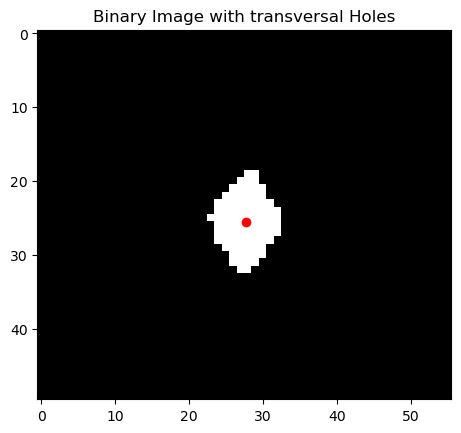

Number of holes found: 1
Hole centers: [(25.558139534883722, 27.75581395348837)]


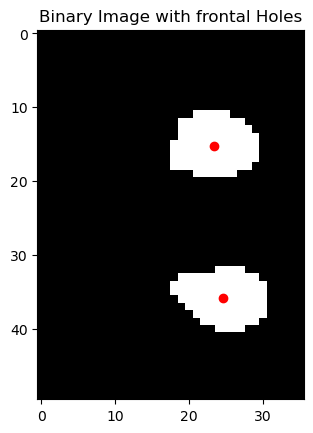

Number of holes found: 2
Hole centers: [(15.170454545454545, 23.420454545454547), (35.80232558139535, 24.651162790697676)]


In [ ]:
#Testing cell
output_img_info, output_img_data = read_data()
value = 30
array = (output_img_data == value).astype(np.uint8) * value
temp, sagital_start, frontal_start, transversal_start = crop_image(array)

# Example binary image (object with holes)
binary_image = (temp == value).astype(np.uint8) * 1

#For frontal they are organised (Sagital slice, Transversal)
#For transversal they are organised (Sagital, Frontal)
transversal_holes,frontal_holes = hole_find(binary_image, True, True)

Slice start:21.
slice index:0.
 -1^:0


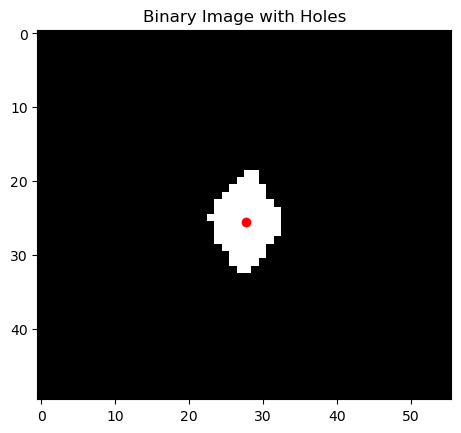

Number of holes found: 1
Hole centers: [(25.558139534883722, 27.75581395348837)]


In [19]:
#Real working cell
output_img_info, output_img_data = read_data()
value = 30
array = (output_img_data == value).astype(np.uint8) * value
tmp, sagital_start, frontal_start, transversal_start = cut_body(array, value, plot=True)
plot_segmentation(tmp, value)
tmp2 = restore_array(output_img_data, tmp, sagital_start, frontal_start, transversal_start, value)
plot_segmentation(tmp2, value)

26
Slice start:9.
slice index:8.
 -1^:2


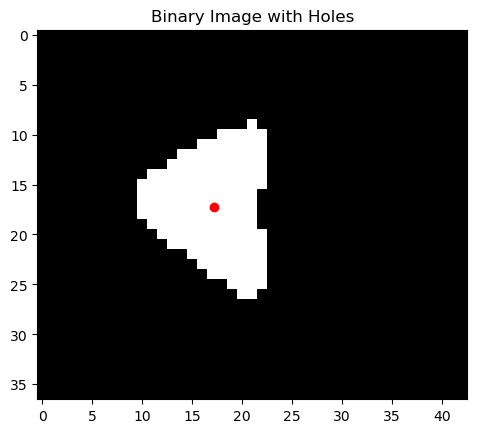

Number of holes found: 1
Hole centers: [(17.24342105263158, 17.19736842105263)]
27
Slice start:17.
slice index:0.
 -1^:0


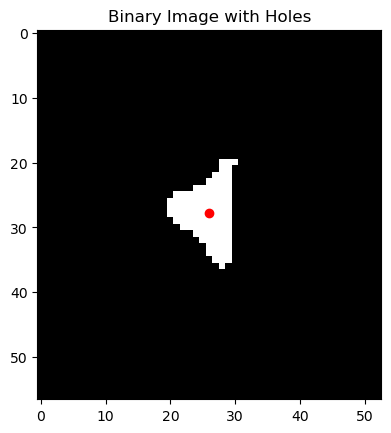

Number of holes found: 1
Hole centers: [(27.783505154639176, 25.896907216494846)]
28
Slice start:24.
slice index:2.
 -1^:2


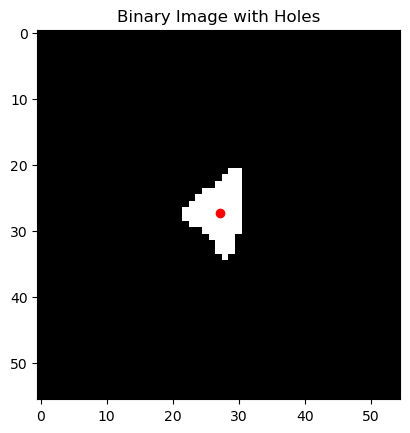

Number of holes found: 1
Hole centers: [(27.21917808219178, 27.08219178082192)]
29
Slice start:23.
slice index:0.
 -1^:0


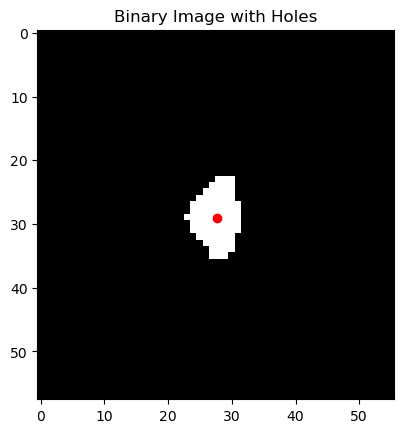

Number of holes found: 1
Hole centers: [(29.0, 27.68831168831169)]
30
Slice start:21.
slice index:0.
 -1^:0


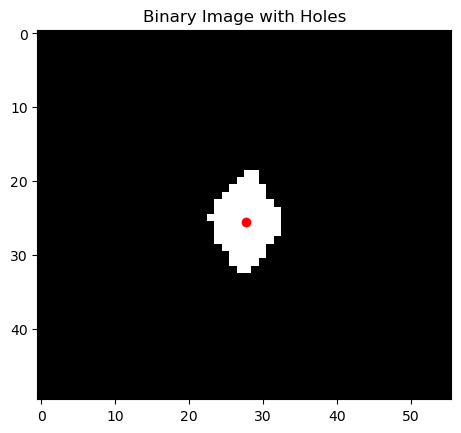

Number of holes found: 1
Hole centers: [(25.558139534883722, 27.75581395348837)]
31
Slice start:19.
slice index:0.
 -1^:0


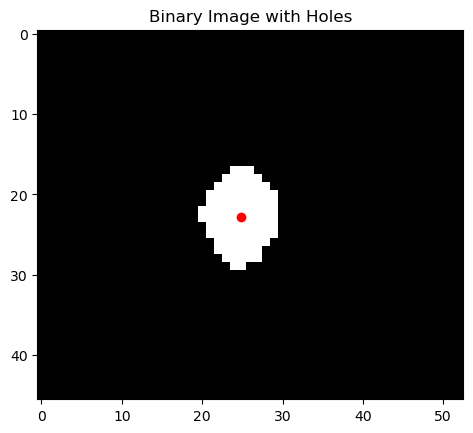

Number of holes found: 1
Hole centers: [(22.813186813186814, 24.846153846153847)]
32
Slice start:15.
slice index:0.
 -1^:0


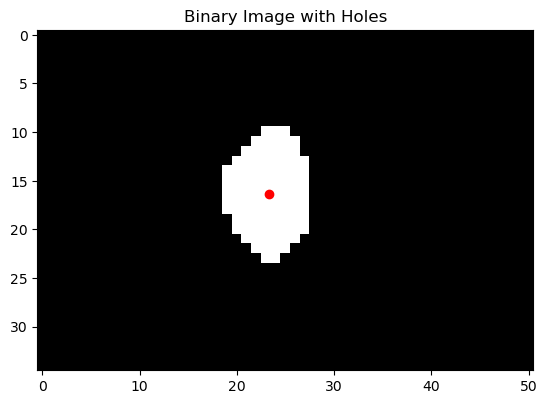

Number of holes found: 1
Hole centers: [(16.347368421052632, 23.305263157894736)]
33
Slice start:14.
slice index:0.
 -1^:0


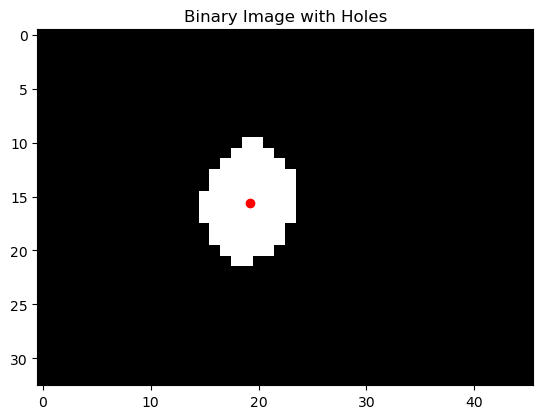

Number of holes found: 1
Hole centers: [(15.592105263157896, 19.17105263157895)]
34
Slice start:20.
slice index:0.
 -1^:0


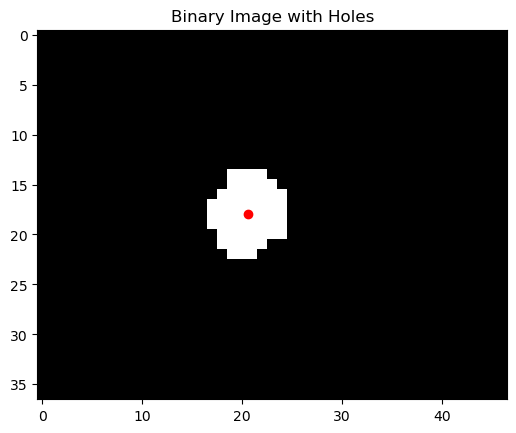

Number of holes found: 1
Hole centers: [(17.927272727272726, 20.6)]
35
Slice start:26.
slice index:0.
 -1^:0


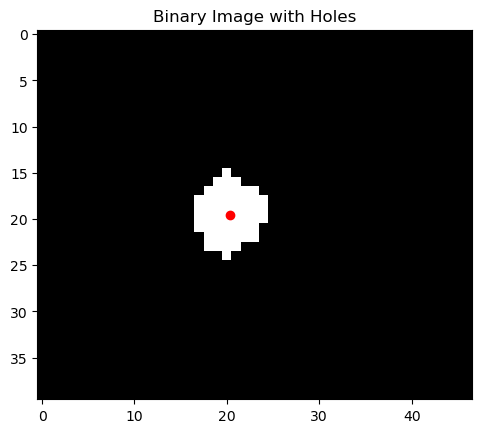

Number of holes found: 1
Hole centers: [(19.53846153846154, 20.307692307692307)]
36
Slice start:32.
slice index:0.
 -1^:0


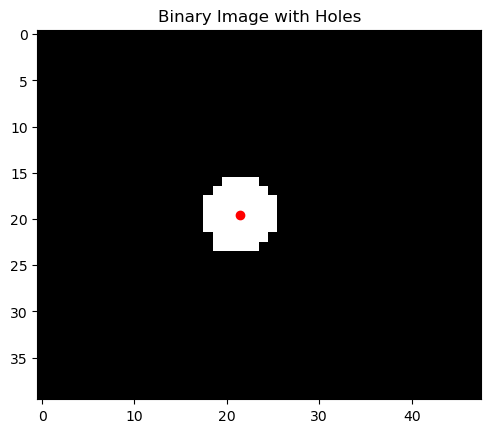

Number of holes found: 1
Hole centers: [(19.566037735849058, 21.452830188679247)]
37
Slice start:29.
slice index:0.
 -1^:0


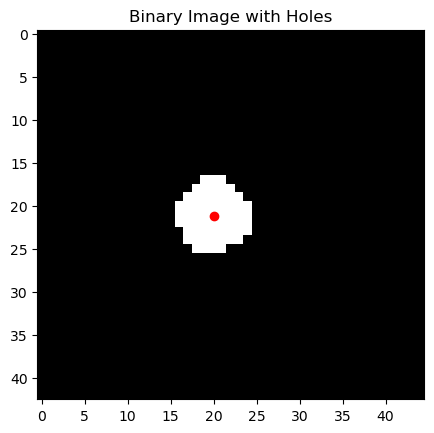

Number of holes found: 1
Hole centers: [(21.19672131147541, 20.0327868852459)]
38
Slice start:31.
slice index:0.
 -1^:0


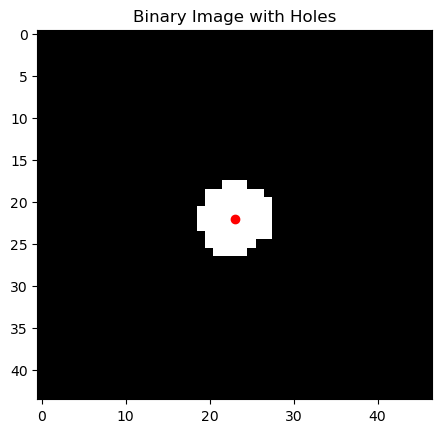

Number of holes found: 1
Hole centers: [(22.015873015873016, 23.047619047619047)]
39
Slice start:27.
slice index:0.
 -1^:0


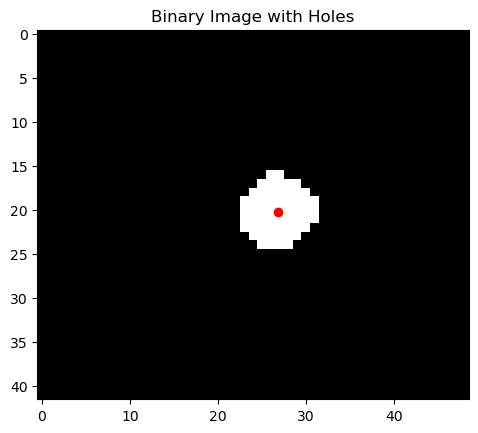

Number of holes found: 1
Hole centers: [(20.220338983050848, 26.83050847457627)]
40
Slice start:23.
slice index:0.
 -1^:0


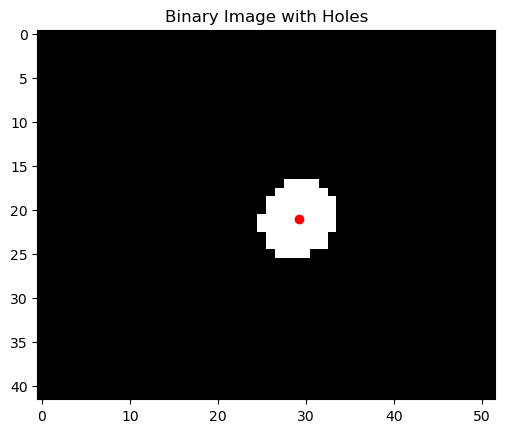

Number of holes found: 1
Hole centers: [(21.032258064516128, 29.177419354838708)]
41
Slice start:17.
slice index:0.
 -1^:0


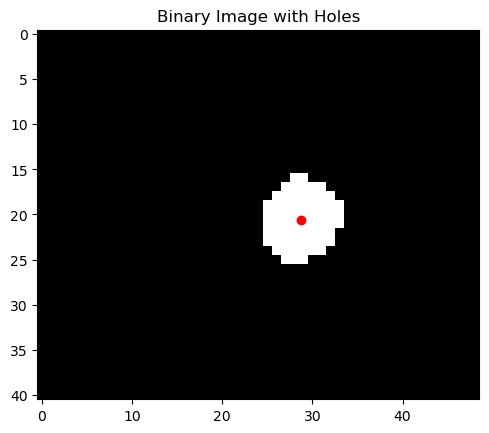

Number of holes found: 1
Hole centers: [(20.636363636363637, 28.772727272727273)]
42
Slice start:13.
slice index:0.
 -1^:0


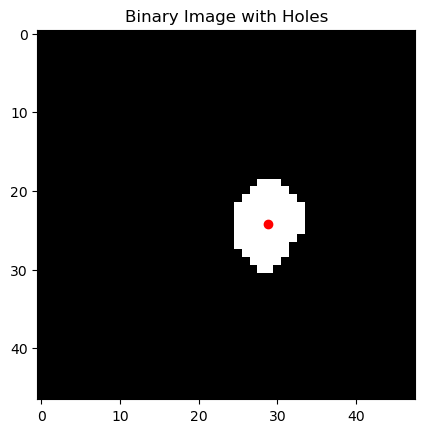

Number of holes found: 1
Hole centers: [(24.243589743589745, 28.78205128205128)]
43
Slice start:11.
slice index:0.
 -1^:0


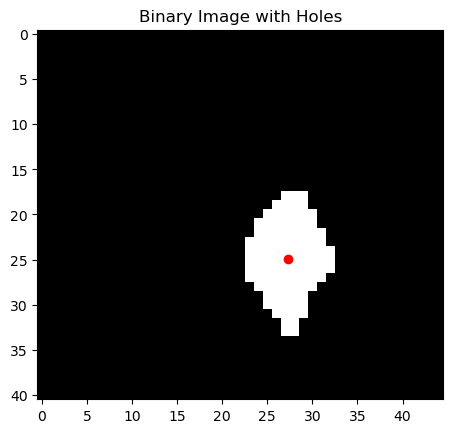

Number of holes found: 1
Hole centers: [(24.93069306930693, 27.306930693069308)]
44
There were no vertebrae for this label


In [20]:
output_img_nifti, output_img_data = read_data()
values = np.unique(output_img_data)
values = values[1:]
for value in values:
    print(value)
    array = (output_img_data == value).astype(np.uint8) * value
    tmp, sagital_start, frontal_start, transversal_start = cut_body(array, value, plot=True)
    output_img_data = restore_array(output_img_data, tmp, sagital_start, frontal_start, transversal_start, value)
plot_segmentation(output_img_data, value=30)

In [48]:
data = read_data()
value=30
array = (output_img_data == value).astype(np.uint8) * value
#array,_,_,_ = crop_image(array)
plot_segmentation(array, value)

### Save results

In [71]:
print(output_img_data.shape)
nii_img = nib.Nifti1Image(output_img_data, affine=np.eye(4))  # Identity matrix as default affine

# Save the NIfTI file
nib.save(nii_img, r'Data\\s0011\\Cropped_segmentation.nii')

(311, 311, 431)
